# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.12

analysis for dataset:

dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'

rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'

In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

77808


## 0.1 Folders

In [2]:
save_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0706')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")

168 fovs detected
Use segmentation_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Segmentation
Use cand_spot_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\CandSpots
Use decoder_folder: \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\Decoder


pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Translate segmentation

## 1.1 load rotation

In [3]:
reload(ia.correction_tools.alignment)

<module 'ImageAnalysis3.correction_tools.alignment' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\correction_tools\\alignment.py'>

In [4]:
# generate alignment
dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304'
rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors'

rna_alignment_file = os.path.join(rna_data_folder, 'Alignment', '10x_positions_before.txt')
dna_alignment_file = os.path.join(dna_data_folder, 'Alignment', '10x_positions_after.txt')
print(rna_alignment_file, '\n', dna_alignment_file)
print(os.path.exists(rna_alignment_file), os.path.exists(dna_alignment_file))
R, t = ia.correction_tools.alignment.align_manual_points(rna_alignment_file, dna_alignment_file,
                                                         save_folder=analysis_folder)

\\10.245.74.158\Chromatin_NAS_0\20220304-P_brain_M1_nonclear_adaptors\Alignment\10x_positions_before.txt 
 \\10.245.74.158\Chromatin_NAS_4\20220316-P_brain_CTP11-12-13_from_0304\Alignment\10x_positions_after.txt
True True
- Manually picked points aligned, rotation:
[[ 0.99997433 -0.00716481]
 [ 0.00716481  0.99997433]],
 translation:[-238.54348979 -722.53301093]
-- \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\rotation.npy exists, skip.
-- \\10.245.74.158\Chromatin_NAS_8\Analyzed_data\20220316-P_brain_CTP11-12-13_from_0304\Analysis_0706\translation.npy exists, skip.


# 1.2 save DAPI image for RNA

In [5]:
# MERFISH segmentation info
merfish_segmentation_folder = r'\\10.245.74.158\Chromatin_NAS_8\MERFISH\v2\20220304-storm6_M1\CellPoseSegment\features'
merfish_dapi_folder = os.path.join(analysis_folder, 'Merfish_DAPI')
if not os.path.exists(merfish_dapi_folder):
    print(merfish_dapi_folder)
    os.makedirs(merfish_dapi_folder)

In [6]:
from tqdm import tqdm
rna_fds, rna_fovs = ia.io_tools.data.get_folders(rna_data_folder)
ref_fd = rna_fds[0]

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 11
- Number of field of views: 168


In [7]:
overwrite_dapi = False
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

for _fov_id in tqdm(save_fov_ids):
    _dapi_savefile = os.path.join(merfish_dapi_folder, rna_fovs[_fov_id].replace('.dax', '_Dapi.npy'))
    if overwrite_dapi or not os.path.exists(_dapi_savefile):
        # load 
        _dapi_filename = os.path.join(ref_fd, rna_fovs[_fov_id])
        _ref_cls = ia.classes.preprocess.DaxProcesser(_dapi_filename, 
                                                      CorrectionFolder=correction_folder, DriftChannel=488, DapiChannel=405)
        _ref_cls._load_image(sel_channels=[405])
        _ref_cls._corr_illumination(correction_channels=[405])
        _dapi_im = _ref_cls.im_405
        # save
        np.save(_dapi_savefile.split('.npy')[0], _dapi_im)

100%|████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:00<00:00, 1844.77it/s]


## 1.3 Prepare args

In [8]:
import multiprocessing as mp
# savefile for segmentations
#_total_seg_save_file = os.path.join(segmentation_folder, 'full_segmentation.hdf5')
# required parameters
rna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
Zcoords = np.arange(0,12.5,0.25) # z-coordinates of all z-planes in this experiment
seg_align_params = {}
overwrite_segmentation = False
plot_segmentation = True

In [9]:
%%time
# initiate locks
_manager = mp.Manager()
# savefile lock
#_segmentation_savefile_lock = _manager.RLock()
_segmentation_savefile_lock = None # do not use lock if saved in multiple files
_seg_align_args = []
# prepare kwargs
for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):
    # segmentation filename
    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    _rna_feature_filename = os.path.join(merfish_segmentation_folder, f"feature_data_{_fov_id}.hdf5")
    _rna_dapi_filename = os.path.join(merfish_dapi_folder, 
                                      os.path.basename(_save_filename).replace('.hdf5', '_Dapi.npy'))
    _args = (_fov_id, Zcoords, _rna_feature_filename, _rna_dapi_filename,
             _save_filename, rna_microscope_file, dna_microscope_file, R, 
             _segmentation_savefile, True, _segmentation_savefile_lock, 
             seg_align_params, plot_segmentation, overwrite_segmentation, False, False, True,
             )
    _seg_align_args.append(_args)
print(len(_seg_align_args))

168
Wall time: 114 ms


## 1.4 test run and plot

In [10]:
reload(ia.segmentation_tools)

<module 'ImageAnalysis3.segmentation_tools' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\__init__.py'>

In [31]:
reload(ia.correction_tools.translate)

<module 'ImageAnalysis3.correction_tools.translate' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\correction_tools\\translate.py'>

In [32]:
import ImageAnalysis3.segmentation_tools.cell
reload(ia.segmentation_tools.cell)
# test run one fov
sel_fov = 0
_seg_cls = ia.segmentation_tools.cell.Align_Segmentation(
    _seg_align_args[sel_fov][2],_seg_align_args[sel_fov][3],_seg_align_args[sel_fov][4],
    rna_microscope_file, dna_microscope_file, R, debug=True, 
)

dna_mask, _full_rna_mask, _rna_dapi, _rot_dna_dapi, _dna_dapi = _seg_cls._generate_dna_mask(_seg_align_args[sel_fov][1]) 

- reconstruct 50 layers
-- start calculating drift with rotation between images
-- start aligning given source image to given reference image.
-- drift 0: [ 0.1 77.3 27.4] in 2.668s.
-- drift 1: [-0.3 76.3 28.8] in 2.549s.
-- drift 2: [ 0.1 77.6 28.6] in 2.518s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
--- drift: [-3.000e-02  7.707e+01  2.827e+01] pixels
- generate rotation matrix
- rotate segmentation label with rotation matrix


<IPython.core.display.Javascript object>


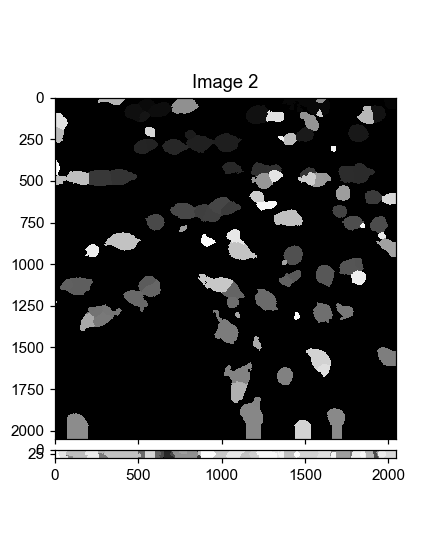

In [33]:
%matplotlib notebook
visual_tools.imshow_mark_3d_v2([_dna_dapi, dna_mask])

<IPython.core.display.Javascript object>


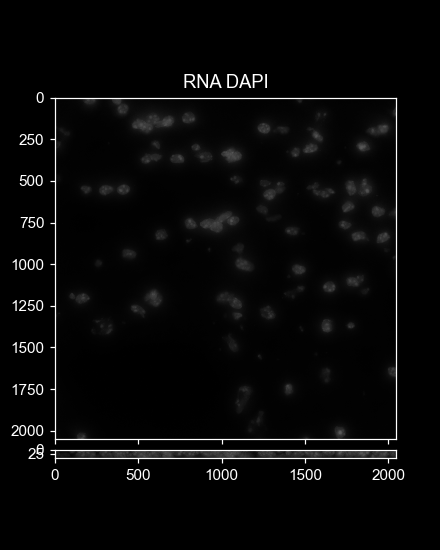

In [34]:
%matplotlib notebook
plt.style.use('dark_background')
_vis = ia.visual_tools.imshow_mark_3d_v2([_dna_dapi, _rna_dapi, _rot_dna_dapi], 
                                         #min_max_default=[10000,50000], 
                                         image_names=['DNA DAPI', 'RNA DAPI', 'Rotated DNA DAPI'])
#_vis.f.savefig(os.path.join(segmentation_folder, 'test_dna_dapi.png'), transparent=True)

## 1.5 batch run translation

In [35]:
%%time
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
# Multiprocessing
print(f"- Start multiprocessing segmentation alignment", end=' ')
_start_time = time.time()
with mp.Pool(12) as _seg_pool: # 6 cores recommended because of RAM comsumption
    # start multiprocessing
    _seg_pool.starmap(_batch_align_segmentation, _seg_align_args, chunksize=1)
    # close multiprocessing
    _seg_pool.close()
    _seg_pool.join()
    _seg_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing segmentation alignment finish in 2358.186s. 
Wall time: 39min 18s


### 1.5.2 non-parallel version

In [73]:
reload(ia.segmentation_tools.cell)

<module 'ImageAnalysis3.segmentation_tools.cell' from 'E:\\Users\\puzheng\\Documents\\ImageAnalysis3\\segmentation_tools\\cell.py'>

In [ ]:
%matplotlib inline
reload(ia.segmentation_tools.cell)
reload(correction_tools.alignment)
from ImageAnalysis3.segmentation_tools.cell import _batch_align_segmentation
for _args in _seg_align_args:
    _outputs = _batch_align_segmentation(*_args)